# Love Song Lyrics Generator Challenge
One of my peers challenged us to create a lovesong based on a dataset that was provided. The dataset contained lyrics from various lovesongs. The implementation that I have chosen is by using a Character-Level LSTM that would generate the lyrics character-by-character.

Let's first load our dependencies.

In [0]:
import os
import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from torch import nn
from google.colab import drive

The next step is to retrieve the dataset provided.

In [0]:
drive.mount('/content/drive')

os.chdir('drive/My Drive/')

with open('Output1.txt', 'r') as f:
    original_data = f.read()

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


To add a little twist to the dataset. I've decided to load in a dataset provided by *Sergey Kuznetsov* from Kaggle which is the 55000+ Song Lyrics dataset. Link to the dataset: https://www.kaggle.com/mousehead/songlyrics

In [0]:
os.chdir('SongLyrics/')
data = pd.read_csv('songdata.csv')

Since most of these songs are not related to lovesongs at all. We may end up with a model that produces lyrics from multiple genres. We want to make sure that the songs that we use are only love-songs. Let's retrieve only the songs with the word "love" in it. Let's also pre-process it and remove the commas and periods.

In [0]:
dataset = data[data['song'].str.lower().str.contains('love')].copy()
dataset['text'] = dataset['text'].apply(lambda x: x.replace(',', ''))
dataset['text'] = dataset['text'].apply(lambda x: x.replace('.', ''))

Now let's combine the original dataset and the Kaggle dataset into one single list of words.

In [0]:
text = ' '.join(dataset['text'])
text = original_data + ' ' + text
print("length of original dataset " + str(len(original_data)))
print("length of original+kaggle dataset " + str(len(text)))

length of original dataset 902550
length of original+kaggle dataset 4746168


We've increased the original dataset's length by more than 5 times! Now let's add in the pre-processing step by tokenizing our dataset and creating our mapping dictionary.

In [0]:
chars = tuple(set(text))
int2char = dict(enumerate(chars))
char2int = {ch: ii for ii, ch in int2char.items()}

encoded = [char2int[m] for m in text]
encoded = np.array(encoded)

Let's add a get_batches() function that would allow us to split our initial sequence into batches and iterate through it through a window called the sequence length.

In [0]:
def get_batches(arr, batch_size, seq_length):
    
    n_batches = int(len(arr) / (seq_length * batch_size))
  
    arr = arr[:int(batch_size * n_batches * seq_length)]
    
    arr = arr.reshape(batch_size, -1)
    
    for n in range(0, arr.shape[1], seq_length):
        x = arr[:,n:n+seq_length]
        y = arr[:,n+1:(n+1)+seq_length]
        if len(y[0]) != len(x[0]):
            z = np.zeros((batch_size,1), dtype=np.int64)
            y = np.append(y, z, axis=1)
        yield x, y

Now let's check if we can train on GPU then define our network.

In [0]:
train_on_gpu = torch.cuda.is_available()

class CharRNN(nn.Module):
    
    def __init__(self, tokens, n_hidden=256, n_layers=2,
                               drop_prob=0.5, lr=0.001):
        super().__init__()
        self.drop_prob = drop_prob
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.lr = lr
        
        self.chars = tokens
        self.int2char = dict(enumerate(self.chars))
        self.char2int = {ch: ii for ii, ch in self.int2char.items()}
        
        self.lstm = nn.LSTM(len(tokens), n_hidden, n_layers, 
                            dropout=drop_prob, batch_first=True)
        self.dropout = nn.Dropout(drop_prob)
        self.fc = nn.Linear(n_hidden, len(self.chars))
  
    
    def forward(self, x, hidden):
                
        r_out, hidden = self.lstm(x, hidden)

        r_out = self.dropout(r_out)
        r_out = r_out.contiguous().view(-1, self.n_hidden)
        
        out = self.fc(r_out)
  
        return out, hidden
    
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        
        if (train_on_gpu):
            hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_().cuda(),
                  weight.new(self.n_layers, batch_size, self.n_hidden).zero_().cuda())
        else:
            hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_(),
                      weight.new(self.n_layers, batch_size, self.n_hidden).zero_())
        
        return hidden
        

Let's add in our training loop that would allow us to optimize our network's parameters.

In [0]:
def train(net, data, epochs=10, batch_size=10, seq_length=50, lr=0.001, clip=5, val_frac=0.1, print_every=10):
    step_plot = [] # We'll use these for plotting later
    train_loss_plot = []
    valid_loss_plot = []

    net.train()

    valid_loss_min = np.Inf # We want to save our best model with the lowest validation loss

    opt = torch.optim.Adam(net.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    val_idx = int(len(data)*(1-val_frac))
    data, val_data = data[:val_idx], data[val_idx:]
    
    if(train_on_gpu):
        net.cuda()
    
    counter = 0
    n_chars = len(net.chars)
    for e in range(epochs):
        h = net.init_hidden(batch_size)
        
        for x, y in get_batches(data, batch_size, seq_length):
            counter += 1
            
            x = torch.from_numpy(x)
            # Use functional library's one_hot function to one-hot encode our data.
            x = F.one_hot(x, num_classes=n_chars)


            targets = torch.from_numpy(y)
            inputs = x.float()
            if(train_on_gpu):
                inputs, targets = inputs.cuda(), targets.cuda()

            h = tuple([each.data for each in h])
            net.zero_grad()

            output, h = net(inputs, h)
            loss = criterion(output, targets.view(batch_size*seq_length).long())
            loss.backward()
            nn.utils.clip_grad_norm_(net.parameters(), clip)
            opt.step()

            # Check if step count has reached to calculate for validation loss
            if counter % print_every == 0:
                val_h = net.init_hidden(batch_size)
                val_losses = []
                # Set to evaluation mode so there won't be any gradient calculation.
                net.eval()
                for x, y in get_batches(val_data, batch_size, seq_length):
                    x = torch.from_numpy(x)
                    x = F.one_hot(x, num_classes=n_chars)
                    y = torch.from_numpy(y)
                    val_h = tuple([each.data for each in val_h])
                    inputs, targets = x.float(), y
                    if(train_on_gpu):
                        inputs, targets = inputs.cuda(), targets.cuda()
                    output, val_h = net(inputs, val_h)
                    val_loss = criterion(output, targets.view(batch_size * seq_length).long())

                    val_losses.append(val_loss.item())

                net.train() # Go back to training

                print("Epoch: " + str(e+1) + " Train Loss: " + str(loss.item()) \
                      + " Validation Loss: " + str(np.mean(val_losses)))
                
                # append our results to a list for plotting later
                step_plot.append(counter)
                train_loss_plot.append(loss.item())
                valid_loss_plot.append(np.mean(val_losses))
                
                if np.mean(val_losses) <= valid_loss_min: # Check if our validation loss reached a new minimum
                    print("Val loss decreased. Save model.")
                    torch.save(net.state_dict(), 'model.pt')
                    valid_loss_min = np.mean(val_losses)

    # visualize our train loss and valid loss
    plt.plot(step_plot, train_loss_plot, 'r--')
    plt.plot(step_plot, valid_loss_plot, 'b-')
    plt.legend(['Training Loss', 'Valid Loss'])
    plt.xlabel('Step')
    plt.ylabel('Loss')
    plt.show();

Now let's instantiate our model and define our parameters.

In [0]:
n_hidden=512
n_layers=3

net = CharRNN(chars, n_hidden, n_layers)

Let's train our model! Let's also make sure to save the model when it reaches its lowest validation loss.

Epoch: 1 Train Loss: 2.812223434448242 Validation Loss: 2.505034369391364
Val loss decreased. Save model.
Epoch: 1 Train Loss: 2.3502137660980225 Validation Loss: 2.0453730273891138
Val loss decreased. Save model.
Epoch: 1 Train Loss: 2.0833678245544434 Validation Loss: 1.8047665856979989
Val loss decreased. Save model.
Epoch: 1 Train Loss: 1.9701809883117676 Validation Loss: 1.664698359128591
Val loss decreased. Save model.
Epoch: 1 Train Loss: 1.8102957010269165 Validation Loss: 1.5769986929120243
Val loss decreased. Save model.
Epoch: 1 Train Loss: 1.7510298490524292 Validation Loss: 1.5225916102125838
Val loss decreased. Save model.
Epoch: 2 Train Loss: 1.656541347503662 Validation Loss: 1.4765633699056264
Val loss decreased. Save model.
Epoch: 2 Train Loss: 1.6070683002471924 Validation Loss: 1.4422536717878807
Val loss decreased. Save model.
Epoch: 2 Train Loss: 1.574215054512024 Validation Loss: 1.408131974774438
Val loss decreased. Save model.
Epoch: 2 Train Loss: 1.54710948467

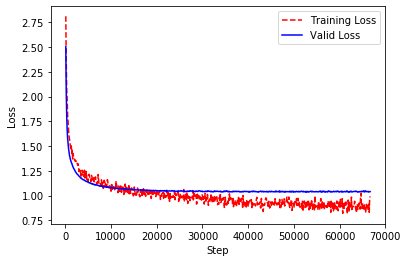

In [0]:
batch_size = 80
seq_length = 80
n_epochs = 100

# train the model
train(net, 
      encoded,
      epochs = n_epochs,
      batch_size = batch_size,
      seq_length = seq_length,
      lr = 0.001,
      print_every = 100)

As seen in the plot above, the validation loss stops decreasing at some point during the training. 
After the network has been trained let's add functions for top-k sampling and for generating text.

In [0]:
def predict(net, char, h=None, top_k=None):
        x = np.array([[net.char2int[char]]])

        x = torch.from_numpy(x)
        # Use functional library's one_hot function to one-hot encode our data.
        x = F.one_hot(x, num_classes=len(net.chars))
        inputs = x.float()

        if(train_on_gpu):
            inputs = inputs.cuda()

        h = tuple([each.data for each in h])
        out, h = net(inputs, h)
        p = F.softmax(out, dim=1).data

        if(train_on_gpu):
            p = p.cpu()
        if top_k is None:
            top_ch = np.arange(len(net.chars))
        else:
            p, top_ch = p.topk(top_k)
            top_ch = top_ch.numpy().squeeze()

        p = p.numpy().squeeze()
        char = np.random.choice(top_ch, p=p/p.sum())
      
        return net.int2char[char], h

def sample(net, size, prime='The', top_k=None):
        
    if(train_on_gpu):
        net.cuda()
    else:
        net.cpu()
    
    net.eval()

    chars = [ch for ch in prime]
    h = net.init_hidden(1)
    for ch in prime:
        char, h = predict(net, ch, h, top_k=top_k)

    chars.append(char)

    for ii in range(size):
        char, h = predict(net, chars[-1], h, top_k=top_k)
        chars.append(char)

    return ''.join(chars)

Let's create our song that starts with the word love! But first let's get the mean song length so we'll know how long our song needs to be.

In [0]:
mean_song_length = dataset['text'].apply(lambda x:len(x)).mean()

With this length, let's cast it to an integer and let's finally create our love song!

In [0]:
net.load_state_dict(torch.load('model.pt'))
print(sample(net, int(mean_song_length), prime='Hanika', top_k=2))

Hanikation  
And the stars are shaking down on you again  
I'm a love like a shame  
I wanna be your lovin' way  
  
I want the world and I want you  
And if I'm always with you  
I want to be loved  
I'm in love with you  
I wanna feel what love is  
I know I know you can show me  
I wanna feel what love is  
I'll do anything you want to make me cry  
I don't want to be with you more than your lovin' way  
I want you to share my love with you  
  
I want to show you what love is if you want me  
I don't want you to stop my life  
  
You can take me away  
I'm not trying not to leave your faith in me  
I'm goin' a little longer  
I can't believe that I could never find  
I didn't know I'm always wrong  
  
And I'm so in love with you  
I want your love tonight  
I will always stop the world  
To be with you and I can't live without  
I wanna feel you  
I'll buy you a little baby  
I'll be your life and tell you that I don't wanna be  
I don't want you to stop and tell you that I'm a li

In [0]:
print(sample(net, int(mean_song_length), prime='Hanika', top_k=2))

Hanika  
Always livin' in a dangerous time

 We got to get out of this love of my life  
I'm a lover start the word that I was standing in the morning  
I want to be the one to say that you love me  
  
I wanna be your man  
I know you love  
I want to stay this way in love with you

 I want to say it again  
  
[Chorus:]  
  
I love to love you baby  
I love to love you baby  
I love to love you baby  
I love to love you baby (I love all love me)  
I'll be there for you  
  
I was a love like the woman in love  
With the stars above  
And the stars are gone  
And I'm standing on the road  
I will love you  
I will always love you

 I've got to be the one to be with you  
I'm gonna give you all my love all my love  
I wanna little love  
Give you love give you love  
  
I've got my love to keep me warm  
  
I wanna little love  
Give me love  
  
I wanna be loved  
I wanna be loved  
I'm in love love love  
I wanna little love  
Give me love  
Give me love  
Give me love  
Give you lov

In [0]:
print(sample(net, int(mean_song_length), prime='Hanika', top_k=2))

Hanika  
I wanna be your man  
  
I'm gonna give you all my loving  
I'm gonna give you all my loving  
I got love took you  
I wanna be inside your superlove  
I love to love you baby  
  
I love this love oh yeah  
I love to love you baby  
  
I'll be there for you  
  
I want to be your lover baby  
I wanna be your lover now  
  
You're the one that makes me feel like I do  
I want to be your lover boy  
I wanna feel what love is I know you love  
I want your love I want your love  
I'll do anything you want  
I want you to show me  
  
I wanna be loved  
I just called to say I love you  
I wanna feel what love is  
I wanna be loved  
I wanna be loved by you  
  
I wanna be loved  
I want you to know I do  
  
[Chorus]  
  
I'm gonna make you love me  
  
I want the whole world to know  
What it is that I've got  
I'm gonna love you more than I do  
I wanna be inside your superlove  
I need to be with you  
  
I wanna love you baby  
I don't wanna love anymore  
  
I don't wanna be 